# TrendAnalysis with satellite data


This juypter notebook is intended to demonstrate how to use the RdTools analysis workflow as implemented with the `rdtools.TrendAnalysis` object-oriented API with satellite weather/irradiance data, such as NSRDB, instead of ground-based sensor data. For a consistent experience, we recommend installing the packages and versions documented in `docs/notebook_requirements.txt`. This can be achieved in your environment by running `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.) This notebook was tested in python 3.12.

The calculations consist of two phases:

1. Import and preliminary calculations: In this step data is important and augmented to enable analysis with RdTools. **No RdTools functions are used in this step. It will vary depending on the particulars of your dataset. Be sure to understand the inputs RdTools requires and make appropriate adjustments.**  
2. Analysis with RdTools: This notebook illustrates the use of the TrendAnalysis API for year on year (YOY) degradation calculations.

This notebook works with data from the NREL PVDAQ `[4] NREL x-Si #1` system.  Note that because this system does not experience significant soiling, the dataset contains a synthesized soiling signal for use in the soiling section of the example.  This notebook automatically downloads and locally caches the dataset used in this example. The data can also be found on the DuraMAT Datahub (https://datahub.duramat.org/dataset/pvdaq-time-series-with-soiling-signal).

In prior versions of RdTools (RdTools<3) we emphasized a clear sky workflow which uses clear sky modeled irradiance rather than measured (sensor) irradiance for analysis. The clear sky analysis served to double check the sensor based result for things like sensor drift, but there was high uncertainty with this approach because aerosal optical depth (AOD), an input to the clear sky irradiance model, can change from year to year. Therefore we now recommend using satellite irradiance data to check that the results with ground measured irradiance are sensible. This can help catch problems with sensor drift.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
%matplotlib inline

In [2]:
#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })
# Register time series plotting in pandas > 1.0
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# Set the random seed for numpy to ensure consistent results
np.random.seed(0)

## Import and preliminary calculations


This section prepares the data necessary for an `rdtools` calculation.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

**The steps of this section may change depending on your data source or the system being considered. Note that nothing in this first section utilizes the `rdtools` library.** Transposition of irradiance and modeling of cell temperature are generally outside the scope of `rdtools`. A variety of tools for these calculations are available in [pvlib](https://github.com/pvlib/pvlib-python).

In [4]:
# Import the example data
file_url = ('https://datahub.duramat.org/dataset/a49bb656-7b36-'
            '437a-8089-1870a40c2a7d/resource/5059bc22-640d-4dd4'
            '-b7b1-1e71da15be24/download/pvdaq_system_4_2010-2016'
            '_subset_soilsignal.csv')
cache_file = 'PVDAQ_system_4_2010-2016_subset_soilsignal.pickle'

try:
    df = pd.read_pickle(cache_file)
except FileNotFoundError:
    df = pd.read_csv(file_url, index_col=0, parse_dates=True)
    df.to_pickle(cache_file)

In [5]:
df = pd.read_csv('new_rdtools_demo_data.csv', index_col=0, parse_dates=True)

In [6]:
df = df.rename(columns = {
    'ac_power':'power_ac',
    'wind_speed': 'wind_speed',
    'ambient_temp': 'Tamb',
    'poa_irradiance': 'poa',
})

# Specify the Metadata
meta = {"latitude": 39.7406,
        "longitude": -105.1774,
        "timezone": 'Etc/GMT+7',
        "gamma_pdc": -0.005,
        "azimuth": 180,
        "tilt": 40,
        "power_dc_rated": 1000.0,
        "temp_model_params":'open_rack_glass_polymer'}

df.index = df.index.tz_localize(meta['timezone'])

# Set the pvlib location
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])

# There is some missing data, but we can infer the frequency from
# the first several data points
freq = pd.infer_freq(df.index[:10])


This example dataset includes a synthetic soiling signal that can be applied onto the PV power data to illustrate the soiling loss and detection capabilities of RdTools.  AC Power is multiplied by soiling to create the synthetic 'power' channel

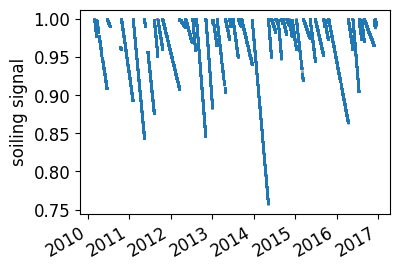

In [7]:
# Plot synthetic soiling signal attached to the dataset
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.soiling, 'o', alpha=0.01)
#ax.set_ylim(0,1500)
fig.autofmt_xdate()
ax.set_ylabel('soiling signal');
df['power'] = df['power_ac'] * df['soiling']

fig

NSRDB data is included in the sample data downloaded by this notebook. In the following cell we transposed the irradiance components from NSRDB to the plane of array (POA).

In [8]:
solar_position = loc.get_solarposition(times=df.index)

nsrdb_poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=meta['tilt'],
    surface_azimuth=meta['azimuth'],
    dni=df['dni_nsrdb'],
    ghi=df['ghi_nsrdb'],
    dhi=df['dhi_nsrdb'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])

nsrdb_poa = nsrdb_poa.dropna()

## Use of the object oriented system analysis API

The first step is to create a `TrendAnalysis` instance containing data to be analyzed and information about the system. Instead of using ground measued irradiance and ambient temperature, we use NSRDB irradiance. Even though our PV data is 1 minute frequency, and our NSRDB data is 30 minute, we can feed both directly to the TrendAnalysis object. RdTools handles the difference in frequency automatically. We will still use the "sensor" leg of the the TrendAnalysis workflow to perform our analysis.

In [9]:
ta = rdtools.TrendAnalysis(df['power'], nsrdb_poa['poa_global'],
                           temperature_ambient=df['ambient_temp_nsrdb'],
                           gamma_pdc=meta['gamma_pdc'],
                           interp_freq=freq,
                           windspeed=df['wind_speed'],
                           power_dc_rated=meta['power_dc_rated'],
                           temperature_model=meta['temp_model_params'])

Once the `TrendAnalysis` object is ready, the `sensor_analysis()` method can be used to deploy the full chain of analysis steps. Results are stored in nested dict, `TrendAnalysis.results`.

New in RdTools 3, there are two filtering steps. The first step occurs after normalization but before aggregation, and the second after aggregation. Filters utilized in the first filtering step can be adjusted by changing the dict `TrendAnalysis.filter_params`. Filters used in the second filtering step can be adjusted by changing the dict `TrendAnalysis.filter_params_aggregated`.

When performing an analysis with satellite data, we recommend adding a clear sky filter to the first filtering step to elliminate noise in variable cloudy conditions. This is acheived by adding the `sensor_clearsky_filter` key to the `filter_params` attribute. It also requires that we run the `set_clearsky` method of our TrendAnalysis object.

In [10]:
ta.set_clearsky(pvlib_location=loc, pv_tilt=meta['tilt'], pv_azimuth=meta['azimuth'], albedo=0.25)
ta.filter_params['sensor_clearsky_filter'] = {}

We can then perform the degradation analysis and examine the results.

In [11]:
ta.sensor_analysis(analyses=['yoy_degradation'])

In [12]:
yoy_results = ta.results['sensor']['yoy_degradation']

In [13]:
# Print the sensor-based analysis p50 degradation rate and confidence interval
print(np.round(yoy_results['p50_rd'], 3))
print(np.round(yoy_results['rd_confidence_interval'], 3))

-0.394
[-0.939  0.102]


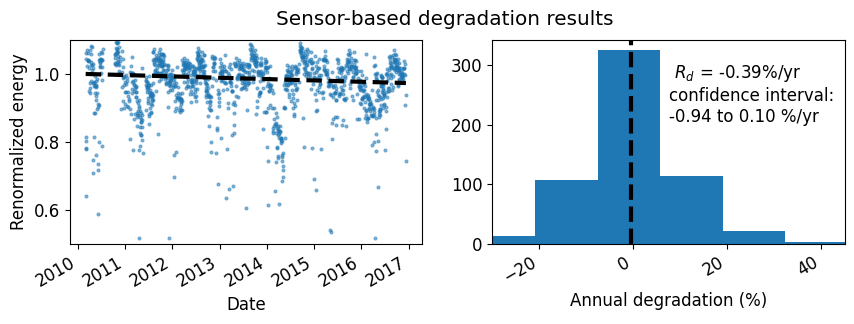

In [14]:
# Plot the sensor based degradation results
fig = ta.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                  scatter_ymin=0.5, scatter_ymax=1.1,
                                  hist_xmin=-30, hist_xmax=45)
fig